In [1]:
## IMPORTS ##
import re
import csv
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

from sklearn import metrics, preprocessing, pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer, RobustScaler

from imblearn.over_sampling import SMOTE, KMeansSMOTE, SVMSMOTE, ADASYN
from imblearn.combine import SMOTEENN

In [2]:
### CONSTANTS ###
DATA_LINE = 15
ORIGINAL_FILENAME = "wine_quality.csv"
CLEANED_FILENAME = "wine_quality_cleaned2.csv"

## DEFAULT K, T, R1, R2 ###
K = 4 # k value
T = 5 # cross value for cross-testing
R1 = 1 # Lower bound of GridSearchCV
R2 = 25 # Upper bound of GridSearchCV

In [3]:
### UTILITY FUNCTION ###
def separate_data_from_label(data):
    X = data.iloc[:, :-1].values
    y = data.iloc[:, 11].values
    return [X, y]

In [4]:
### CLEAN CSV FILE - ONLY RUN ONCE TO GET CLEANED CSV ###
def clean_csv(original_file_path, clean_file_path):
    file = open('{}'.format(ORIGINAL_FILENAME), "r")

    fieldnames = []
    for i in range(0, DATA_LINE-1):
        line = file.readline()
        m = re.search('(?<=@attribute )(.+)(?= \w+)', line)
        if (m):
            fieldnames.append(m.group(0))

    with open('{}'.format(CLEANED_FILENAME), "w", newline="") as clean_csv:
        clean_csv.write(','.join(fieldnames) + "\n")
        for line in file:
            clean_csv.write(file.readline())
    file.close()
    
    
# Clean CSV - only run once to create a clean CSV file.
# clean_csv(ORIGINAL_FILENAME, CLEANED_FILENAME)  // uncomment to get cleaned csv file

In [5]:
###### KEEP UNBALANCED DATASET WITH SCALING ######
print("WINE QUALITY")
data = pd.read_csv("wine_quality_cleaned.csv", delimiter=',')
data

WINE QUALITY


,fixedacid,volacid,citricacid,residualsugar,chlorides,freesulfur,totalsulfur,density,pH,sulphates,alcohol,quality
0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.90,6
1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.80,6
2,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.99380,3.22,0.45,11.00,6
3,8.6,0.23,0.40,4.2,0.035,17.0,109.0,0.99470,3.14,0.53,9.70,5
4,6.6,0.16,0.40,1.5,0.044,48.0,143.0,0.99120,3.54,0.52,12.40,7
...,...,...,...,...,...,...,...,...,...,...,...,...
2445,6.5,0.33,0.38,8.3,0.035,60.0,148.0,0.98964,3.27,0.35,11.50,11
2446,6.6,0.34,0.40,8.1,0.046,68.0,170.0,0.99494,3.15,0.50,9.55,6
2447,6.8,0.22,0.36,1.2,0.052,38.0,127.0,0.99330,3.04,0.54,9.20,5
2448,6.1,0.34,0.29,2.2,0.036,25.0,100.0,0.98938,3.06,0.44,11.80,6


In [6]:
print("GROUP BY QUALITY")
data.groupby(['quality']).count()

GROUP BY QUALITY


,fixedacid,volacid,citricacid,residualsugar,chlorides,freesulfur,totalsulfur,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,1
3,14,14,14,14,14,14,14,14,14,14,14
4,82,82,82,82,82,82,82,82,82,82,82
5,718,718,718,718,718,718,718,718,718,718,718
6,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101
7,442,442,442,442,442,442,442,442,442,442,442
8,87,87,87,87,87,87,87,87,87,87,87
9,4,4,4,4,4,4,4,4,4,4,4
11,1,1,1,1,1,1,1,1,1,1,1


In [7]:
[X, y] = separate_data_from_label(data)

In [8]:
### KNN MODELS ###
def knn(X, y, K, test_ratio=0.2):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0, test_size=test_ratio)
    
    sc = StandardScaler()
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.fit_transform(X_test)
    
    pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=K))
    model = pipeline.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    print("Result of KNN WITH PREPROCESSING using K={} is: \n".format(K))
    labels=[0,3,4,5,6,7,8,9,11]
    cm = confusion_matrix(y_test, y_pred, labels)
    print("Confusion Matrix: \n", cm)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    
    print("Classification report: \n", classification_report(y_test, y_pred))
    print("Training accuracy: ", metrics.accuracy_score(y_test, y_pred))

def knn_untouched(X, y, K, test_ratio=0.2):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0, test_size=test_ratio)
    
    knn = KNeighborsClassifier(n_neighbors=K, n_jobs=-1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    print("Result of KNN with NO PREPROCESSING using K={} is: \n".format(K))
    labels=[0,3,4,5,6,7,8,9,11]
    cm = confusion_matrix(y_test, y_pred, labels)
    print("Confusion Matrix: \n", cm)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels) 
    
    print("Classification report: \n", classification_report(y_test, y_pred))
    print("Training accuracy: ", metrics.accuracy_score(y_test, y_pred))

def knn_with_cross_validation(X, y, K, T, test_ratio=0.2):
    pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=K, n_jobs=-1))
    scores = cross_val_score(pipeline, X, y, cv=T)
    
    print("\n== == == == == == == == KNN - Predefined K = {} + Cross Validation == == == == == == == ==\n".format(K))
    print("scores: ", scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

def knn_with_gridSearchCV(X, y, K, T, R1, R2,test_ratio=0.2):
    search_space = [{'knn__n_neighbors': range(R1, R2+1)}]
    
    sc = StandardScaler()
    X_std = sc.fit_transform(X)
    
    knn = KNeighborsClassifier(n_jobs=-1)
    
    pipeline= Pipeline([('sc', sc), ('knn', knn)])
    clf = GridSearchCV(pipeline, search_space, cv=T, scoring="accuracy")
    clf.fit(X_std, y)

    grid_df = pd.DataFrame(clf.cv_results_).sort_values(
        by=['rank_test_score']).set_index('rank_test_score')
    display_cols = ['param_knn__n_neighbors', "mean_test_score", "std_test_score"]
    
    print("\n== == == == == == == == KNN - GridSearchCV with K = [{},...,{}] == == == == == == == ==\n".format(R1, R2))
    plt.plot(list(range(R1, R2+1)), clf.cv_results_["mean_test_score"])
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    print("Grid result by descending rank test score is: \n{}".format(grid_df[display_cols]))
    print("Best score: ", clf.best_score_)
    print("Best param: ", clf.best_params_)
    print("Best estimator: ", clf.best_estimator_)

    best_line = { key : clf.cv_results_[key][clf.best_index_] for key in clf.cv_results_.keys() }
    print("Best accuracy: %0.2f (+/- %0.2f) when k = %.0f" %
          (best_line['mean_test_score'], best_line['std_test_score'] * 2, best_line['param_knn__n_neighbors']))

Result of KNN with NO PREPROCESSING using K=4 is: 

Confusion Matrix: 
 [[  0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0]
 [  0   1   2   8   2   2   0   0   0]
 [  0   1   5  80  50  11   1   0   0]
 [  0   1   5  76 109  26   3   0   0]
 [  0   0   3  16  44  27   2   0   0]
 [  0   0   1   2   9   1   1   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]]
Classification report: 
               precision    recall  f1-score   support

           3       0.25      1.00      0.40         1
           4       0.12      0.13      0.13        15
           5       0.44      0.54      0.48       148
           6       0.51      0.50      0.50       220
           7       0.40      0.29      0.34        92
           8       0.14      0.07      0.10        14

    accuracy                           0.45       490
   macro avg       0.31      0.42      0.33       490
weighted avg       0.45      0.45      0.44       490

Training

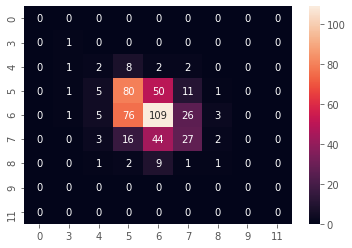

In [9]:
## WITH FULL DATASETS ##
# KNN Models
knn_untouched(X, y, K=K)

Result of KNN WITH PREPROCESSING using K=4 is: 

Confusion Matrix: 
 [[  0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0]
 [  0   0   3   6   6   0   0   0   0]
 [  0   1   4 103  31   8   1   0   0]
 [  0   0   3  63 130  18   6   0   0]
 [  0   0   0   5  59  27   1   0   0]
 [  0   0   0   2   6   6   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]]
Classification report: 
               precision    recall  f1-score   support

           3       0.50      1.00      0.67         1
           4       0.30      0.20      0.24        15
           5       0.58      0.70      0.63       148
           6       0.56      0.59      0.58       220
           7       0.46      0.29      0.36        92
           8       0.00      0.00      0.00        14

    accuracy                           0.54       490
   macro avg       0.40      0.46      0.41       490
weighted avg       0.52      0.54      0.52       490

Training ac

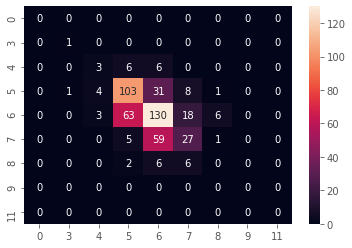

In [10]:
knn(X, y, K=K)

In [11]:
knn_with_cross_validation(X, y, K=K, T=T)

/Users/chinhnguyen/opt/anaconda3/envs/cecs550/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"



== == == == == == == == KNN - Predefined K = 4 + Cross Validation == == == == == == == ==

scores:  [0.48979592 0.51632653 0.43673469 0.52244898 0.51632653]
Accuracy: 0.50 (+/- 0.06)


/Users/chinhnguyen/opt/anaconda3/envs/cecs550/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"



== == == == == == == == KNN - GridSearchCV with K = [1,...,25] == == == == == == == ==

Grid result by descending rank test score is: 
                param_knn__n_neighbors  mean_test_score  std_test_score
rank_test_score                                                        
1                                   21         0.527755        0.023960
2                                   22         0.524082        0.023426
3                                   20         0.523265        0.021311
4                                   11         0.520408        0.022169
5                                   23         0.520000        0.017094
6                                   15         0.519592        0.016049
7                                   19         0.518367        0.012514
7                                   14         0.518367        0.021365
9                                   24         0.517551        0.019472
10                                  18         0.517551        0.021621


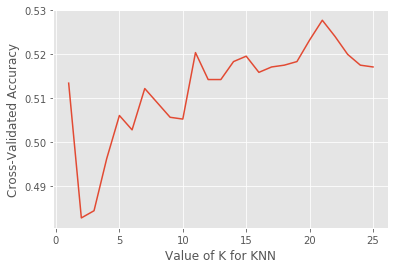

In [12]:
knn_with_gridSearchCV(X, y, K=K, T=T, R1=R1, R2=R2)

In [13]:
###### BALANCE DATASET WITH SCALING ######
# Sampling data
data = pd.read_csv("wine_quality_cleaned.csv", delimiter=',')
data.shape

(2450, 12)

In [14]:
data = data[data.groupby('quality').quality.transform('count') >= 2].copy() # Remove any label with members < 2
data.shape

(2448, 12)

In [15]:
print("GROUP BY QUALITY")
print("We removed quality 0 and 11")
data.groupby(['quality']).count()

GROUP BY QUALITY
We removed quality 0 and 11


,fixedacid,volacid,citricacid,residualsugar,chlorides,freesulfur,totalsulfur,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
3,14,14,14,14,14,14,14,14,14,14,14
4,82,82,82,82,82,82,82,82,82,82,82
5,718,718,718,718,718,718,718,718,718,718,718
6,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101
7,442,442,442,442,442,442,442,442,442,442,442
8,87,87,87,87,87,87,87,87,87,87,87
9,4,4,4,4,4,4,4,4,4,4,4


In [16]:
## Fix imbalance dataset
[X, y] = separate_data_from_label(data)
X_res, y_res = SMOTE(k_neighbors=3, random_state=0).fit_resample(X, y)
print("Original data shape: X.shape = ", X.shape, "y.shape = ", y.shape)
print("New data shape: X.shape = ", X_res.shape, "y.shape = ", y_res.shape)

Original data shape: X.shape =  (2448, 11) y.shape =  (2448,)
New data shape: X.shape =  (7707, 11) y.shape =  (7707,)


In [17]:
# ## SPLIT TRAIN-TEST ##
# X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=0, test_size=0.2)

# ## SCALING FEATURES ##
# sc = StandardScaler()
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.fit_transform(X_test)

Result of KNN WITH PREPROCESSING using K=4 is: 

Confusion Matrix: 
 [[  0   0   0   0   0   0   0   0   0]
 [  0 226   0   0   0   0   0   0   0]
 [  0   3 204   2   0   0   0   0   0]
 [  0   2  32 144  17  14   6   0   0]
 [  0   6  12  68  65  45  13   0   0]
 [  0   2   6   6  27 180  19   0   0]
 [  0   1   0   0   0   5 206   0   0]
 [  0   0   0   0   0   0   0 231   0]
 [  0   0   0   0   0   0   0   0   0]]
Classification report: 
               precision    recall  f1-score   support

           3       0.94      1.00      0.97       226
           4       0.80      0.98      0.88       209
           5       0.65      0.67      0.66       215
           6       0.60      0.31      0.41       209
           7       0.74      0.75      0.74       240
           8       0.84      0.97      0.90       212
           9       1.00      1.00      1.00       231

    accuracy                           0.81      1542
   macro avg       0.80      0.81      0.80      1542
weighted avg

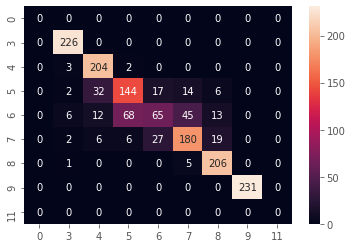

In [18]:
## KNN ##
knn(X_res, y_res, K)

In [19]:
## KNN WITH CROSS VALIDATION ##
knn_with_cross_validation(X_res, y_res, K, T)


== == == == == == == == KNN - Predefined K = 4 + Cross Validation == == == == == == == ==

scores:  [0.78080415 0.79571984 0.78844906 0.82738482 0.81245944]
Accuracy: 0.80 (+/- 0.03)


In [ ]:
## GridsearchCV ##
knn_with_gridSearchCV(X_res, y_res, K=K, T=T, R1=R1, R2=R2)

# REPORT
The original data set is unbalanced with most member aggregated around 5,6,7. We want to see whether KNN is sensitive to this. 

## Original with scaling 
Without scaling, KNN model from scikit-learn with K=4 with no cross-validation yields ~44% accuracy. This accuracy is improved by applying StandardScaling to the features in both training and test. The accuracy, then is 54%. StandardScaler performs the task of Standardization where it changes each feature to have a common scale. After the transformation, each feature will have a mean of 0 and standard deviation of 1. This ensures that different scale of the feature doesn't lead KNN to incorrect classification. However, scaling only improves the accuracy so much. The imbalance in the dataset is still problematic. 

With cross-validation with T = 5, the score ~50% which verifies that our KNN model doesn't suffer from overfitting since ~54% is close to ~50%. 

With gridsearchCV with k range from 1 to 25, the best accuracy is achived at k=21 with 53%. This shows that it wasn't the k value that causes the low accuracy.

## Oversampling with scaling
To fix the imbalance issue, we propose using Synthetic Minority Over-sampling Technique (SMOTE) from imblearn framework to fix the imbalance data problem. SMOTE uses an algorithm generate will new samples for our minority labels by considering k_neighbords from a sample. The lowest k_neighbords=1 which makes the algorithm consider 2 nearest neighbors from the sample. If we keep the original dataset, SMOTE won't work because every label need to have at least 2 samples. However, given the size of our dataset of more than 2000 sample, the outliers such as quality 0 and quality 11 is extremely unlikely. Therefore, we believe it is safe to remove both label from the dataset. Since the next lowest label is quality=9 with 4 members, we decides to use k_neighbors=3 to it is showned that higher k shows a larger benefit (from [1])

With SMOTE, the accuracy improves dramatically. With cross-validation with K=4, the accuracy is at 80%. GridsearchCV shows that k=1 will give us the best accuracy at 86%. The confusion matrix between unbalanced dataset show that most the correct guess are centered around quality that has most members. This makes sense considering how KNN algoritm works. By oversampling our dataset, as seen in the confusion matrix, we bring up the guess accuracy to minority labels as well.

## Reference: 
[1] https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-106. 